In [71]:
import numpy as np
import matplotlib.pyplot as plt
import pytomography
from pytomography.metadata import ObjectMeta, ImageMeta, PSFMeta
from pytomography.transforms import SPECTAttenuationTransform, SPECTPSFTransform
from pytomography.projections import SystemMatrix
# Set device so its faster
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pytomography.device = device

# Last Time

We created an object and attenuation map

In [72]:
dx = 0.3 #cm
x = torch.linspace(-1,1,128)
xv, yv, zv = torch.meshgrid(x,x,x, indexing='ij')
# SPECT Object
obj = (xv**2 + 0.9*zv**2 < 0.5) * (torch.abs(yv)<0.8)
obj = obj.to(torch.float).unsqueeze(dim=0)
# CT Object
mu = (xv**2 + 0.9*zv**2 < 0.3) * (torch.abs(yv)<0.6)
mu = mu.to(torch.float).unsqueeze(dim=0) * 0.05 #cm^-1

Specified the appropriate object/image metadata

In [73]:
object_meta = ObjectMeta(dr=(0.3,0.3,0.3), shape=(128,128,128))
image_meta = ImageMeta(object_meta, angles=np.arange(0,360.,3), radii=25*np.ones(120))
psf_meta = PSFMeta(collimator_slope = 0.03, collimator_intercept=0.1)

Specified the transforms used in the system matrix, and created the system matrix $H$ 

In [74]:
att_transform = SPECTAttenuationTransform(mu)
psf_transform = SPECTPSFTransform(psf_meta)
system_matrix = SystemMatrix(
    obj2obj_transforms = [att_transform,psf_transform],
    im2im_transforms = [],
    object_meta = object_meta,
    image_meta = image_meta)

And then simulated the image:

In [82]:
image = system_matrix.forward(obj)
image = torch.poisson(image)

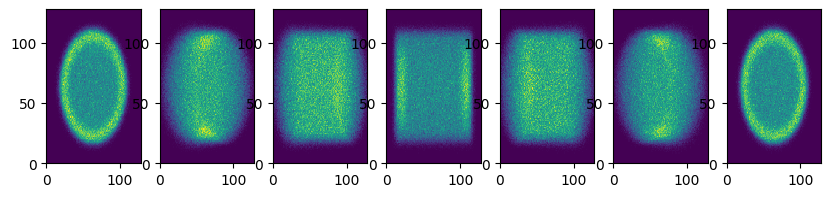

In [83]:
iis = [0,10,20,30,40,50,60]
fig, ax = plt.subplots(1,7,figsize=(10,2))
[a.pcolormesh(image[0,i].cpu().T) for (a, i) in zip(ax, iis)]
plt.show()

# This Time

As shown previously, back projection $H^T g$ alone does not give a good estimate of the initial object $f$

In [86]:
obj_bp = system_matrix.backward(image)

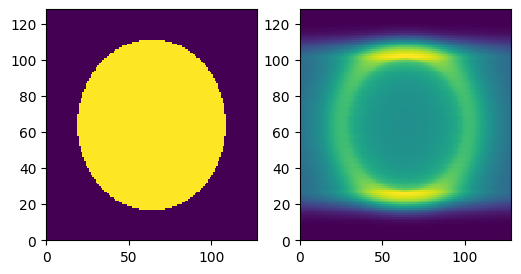

In [87]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
ax[0].pcolormesh(obj[0][:,64].T)
ax[1].pcolormesh(obj_bp.cpu()[0][:,64].T)
plt.show()

The MLEM algorithm can be written as

$$\boxed{f^{(n+1)} = \left[\frac{1}{H^T \vec{1}} H^T \left( \frac{g}{Hf^{(n)}}\right) \right]f^{(n)}}$$

This is an iterative algorithm which requires an initial object guess $f^{(0)}$. The more times you run the algorithm, the better (though the algorithm has a tendency to amplify noise in later iterations, so usually only a couple iterations are used).

In [88]:
# initial prediction
object_prediction = torch.ones((image.shape[0], *system_matrix.object_meta.shape)).to(device)
# number of iterations
n_iters = 30
# parameter delta to avoid division by 0
delta = 1e-11
# Run basic MLEM
for j in range(n_iters):
    ratio = (image+delta) / (system_matrix.forward(object_prediction) + delta)
    object_prediction = object_prediction * system_matrix.backward(ratio, normalize=True)

Then we can plot a coronal slice of the reconstructed object:

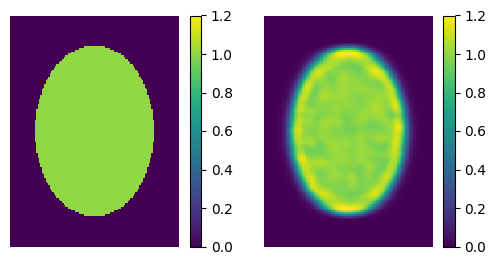

In [90]:
fig, ax = plt.subplots(1,2,figsize=(6,3))
plt.subplot(121)
plt.pcolormesh(obj[0][:,64].T, vmax=1.2)
plt.axis('off')
plt.colorbar()
plt.subplot(122)
plt.pcolormesh(object_prediction.cpu()[0][:,64].T, vmax=1.2)
plt.axis('off')
plt.colorbar()
plt.show()

And a 1 dimensional profile through the center:

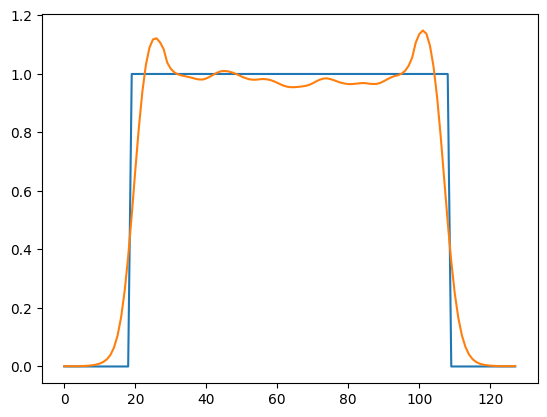

In [91]:
plt.plot(obj[0][:,64,64])
plt.plot(object_prediction.cpu()[0][:,64,64])